## 导入库文件

In [1]:
import os
import re
import cv2 # opencv library
import numpy as np
from os.path import isfile, join
import matplotlib.pyplot as plt

## 导入视频帧
原始视频帧下载地址：[link](https://drive.google.com/file/d/1P0yiO5KlnU8dGgB_L68KB_hjIvUec55f/view)
将视频帧保存在当前工程目录下的frames文件夹中。从该文件夹中，我们将视频帧导入并保留至列表中。

In [2]:
# get file names of the frames
col_frames = os.listdir('frames/')

# sort file names
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# empty list to store the frames
col_images=[]

for i in col_frames:
    # read the frames
    img = cv2.imread('frames/'+i)
    # append the frames to the list
    col_images.append(img)

## 数据探索
让我们显示两个连续的帧：

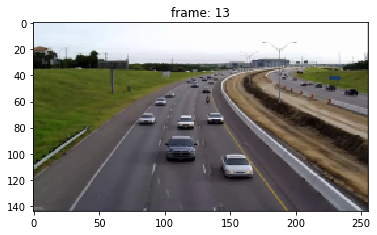

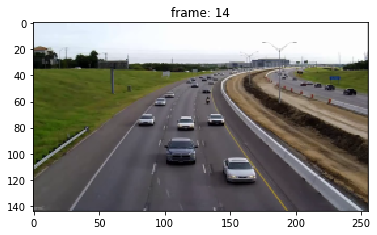

In [3]:
# plot 13th frame
i = 13

for frame in [i, i+1]:
    plt.imshow(cv2.cvtColor(col_images[frame], cv2.COLOR_BGR2RGB))
    plt.title("frame: "+str(frame))
    plt.show()

很难找到这两帧的区别，不是吗？ 如前所述，采用两个连续帧的像素值之差将有助于我们观察运动物体。 因此，让我们在以上两帧使用该技术

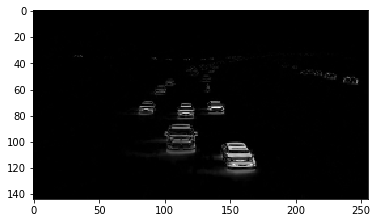

In [4]:
# convert the frames to grayscale
grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)

# plot the image after frame differencing
plt.imshow(cv2.absdiff(grayB, grayA), cmap = 'gray')
plt.show()

现在我们可以清楚地看到第13帧和第14帧中的运动对象。 其他所有不动的东西都被减去。

## 图像预处理
让我们看看将阈值应用于上图之后会发生什么：

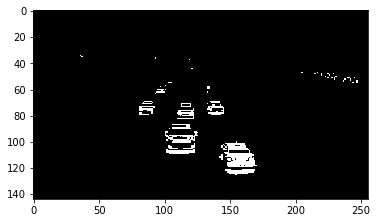

In [6]:
diff_image = cv2.absdiff(grayB, grayA)

# perform image thresholding
ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)

# plot image after thresholding
plt.imshow(thresh, cmap = 'gray')
plt.show()

现在，运动物体（车辆）看起来更有明显，并且大部分噪音（不需要的白色区域）都消失了。 但是，突出显示的区域有些零散。 因此，我们可以对该图像应用图像膨胀：

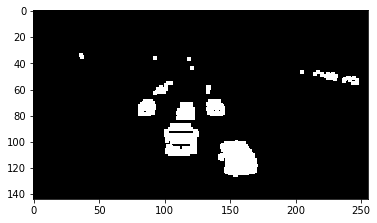

In [7]:
# apply image dilation
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations = 1)

# plot dilated image
plt.imshow(dilated, cmap = 'gray')
plt.show()

移动的对象具有更坚实的突出显示区域。 希望帧中每个对象的轮廓数量不会超过三个。但是，我们不会使用整帧来检测运动中的车辆。 我们将首先选择一个区域，如果车辆进入该区域，则只会检测到该区域。
因此，让我向您展示我们的检测区域： 

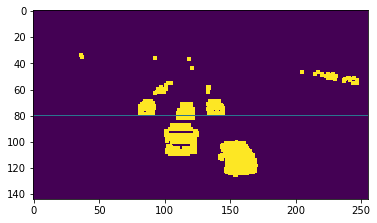

In [8]:
# plot vehicle detection zone
cv2.line(dilated, (0, 80),(256,80), (100, 0, 0))
plt.imshow(dilated)
plt.show()

水平线y = 80以下的区域是我们的车辆检测区域。我们将仅检测此区域中发生的任何移动。如果您想尝试一下该概念，则可以创建自己的检测区域。现在，在上述帧的检测区域中找到轮廓：

In [9]:
# find contours
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

上面的代码查找整个图像中的所有轮廓，并将其保留在变量“轮廓”中。 由于我们只需要查找检测区域中存在的轮廓，因此我们将对发现的轮廓进行几次检查。
第一个检查是轮廓的左上角y坐标是否>=80（我还要再检查x坐标<=200）。另一个检查是轮廓区域应大于等于25。您可以在cv2.contourArea（）函数的帮助下找到轮廓区域。

In [10]:
valid_cntrs = []

for i, cntr in enumerate(contours):
    x,y,w,h = cv2.boundingRect(cntr)
    if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
        valid_cntrs.append(cntr)

# count of discovered contours        
len(valid_cntrs)

6

接下来，让我们绘制轮廓以及原始帧：

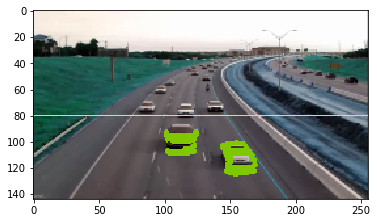

In [11]:
dmy = col_images[13].copy()

cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
plt.imshow(dmy)
plt.show()

酷！仅显示位于检测区域内的那些车辆的轮廓。这就是我们将如何检测所有帧中的车辆。

## 视频中的车辆检测
现在在所有帧上应用相同的图像变换和预处理操作，并找到所需的轮廓了。
重申一下，我们将执行以下步骤：

    1.在每对连续的帧上应用差分帧
    2.在上一步的输出图像上应用图像阈值处理
    3.在上一步的输出图像上执行图像膨胀
    4.在上一步的输出图像中查找轮廓
    5.得到上一步出现在检测区域中出现轮廓的候选清单
    6.将帧与最终轮廓一起保存

In [12]:
# kernel for image dilation
kernel = np.ones((4, 4),np.uint8)

# font style
font = cv2.FONT_HERSHEY_SIMPLEX

# directory to save the ouput frames
pathIn = "contour_frames_3/"

for i in range(len(col_images)-1):
    
    # frame differencing
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    # image thresholding
    ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)
    
    # image dilation
    dilated = cv2.dilate(thresh,kernel,iterations = 1)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    valid_cntrs = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
            if (y >= 90) & (cv2.contourArea(cntr) < 40):
                break
            valid_cntrs.append(cntr)
            
    # add contours to original frames
    dmy = col_images[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
    
    cv2.putText(dmy, "vehicles detected: " + str(len(valid_cntrs)), (55, 15), font, 0.6, (0, 180, 0), 2)
    cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
    cv2.imwrite(pathIn+str(i)+'.png',dmy)  

## 视频生成准备工作
在这里，我们为所有帧中的所有移动车辆添加了轮廓。 现在是时候堆叠帧并创建视频了：

In [13]:
# specify video name
pathOut = 'vehicle_detection_v3.mp4'

# specify frames per second
fps = 14.0

接下来，我们将读取所有的数据帧：

In [14]:
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

In [15]:
files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(files)):
    filename=pathIn + files[i]
    
    #read frames
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

最后，我们将使用以下代码制作目标检测视频：

In [16]:
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])

out.release()